# Unlocking Church Growth: Data Insights from the National Congregations Study

**Author**: Nathan Schaaf <br>
**Date**: July 10, 2024

## References
<ol>
    <li>Chaves, M. (2021, January 25). National Congregations Study, Cumulative Dataset (1998, 2006-2007, 2012, and 2018-2019). The Association of Religion Data Archives. doi:10.17605/OSF.IO/V5ZKB. https://www.thearda.com/data-archive?fid=NCSIV.</li>
    <li>Jones, J. M. (2024, March 25). Church Attendance Has Declined in Most U.S. Religious Groups. Retrieved June 28, 2024, from GALLUP: https://news.gallup.com/poll/642548/church-attendance-declined-religious-groups.aspx.</li>
</ol>


## Objective / Thesis
How can we increase our church attendance? In this analysis we explore the "National Congregations Study, Cumuliative Dataset (1998, 2006-2007, 2012, and 2018-2019)" to look for correlations between congregational offerings such as facilities, worship services, staffing, music, and programs and an increase congregational size. The dataset includes over 5,000 congregations sampled through in-person interviews in four periods between 1998 and 2019. This analysis is inteded for decision-makers within religious congregations.

## Data Understanding and Preparation
Data Cleaning: Ensure the dataset is clean, dealing with missing values, and outliers. <br>
Data Transformation: Create relevant variables, such as attendance growth rates, and standardize/normalize data if necessary.

## Descriptive Analysis
Summary Statistics: Compute basic statistics (mean, median, mode) for variables related to facilities, worship services, staffing, music, programs, and congregational size. <br>
Distribution Analysis: Visualize the distributions of key variables to understand their spread and central tendency.

## Exploratory Data Analysis (EDA)
Correlation Analysis: Use correlation matrices to identify relationships between congregational offerings and attendance.<br>
Visualization: Create visualizations such as histograms, box plots, scatter plots, and heatmaps to explore patterns and trends.

## Inferential Analysis
Hypothesis Testing: Conduct hypothesis tests (e.g., t-tests, ANOVA) to determine if there are statistically significant differences in attendance based on different offerings.

## Regression Analysis
Linear Regression: Model the relationship between congregational size (dependent variable) and offerings (independent variables) using linear regression.<br>
Logistic Regression: If the outcome is categorical (e.g., increased attendance vs. no increase), use logistic regression.

## Multivariate Analysis
Multiple Regression: Extend linear regression to include multiple independent variables to account for the effect of various factors simultaneously.<br>
Principal Component Analysis (PCA): Reduce dimensionality and identify key factors contributing to attendance changes.

## Time Series Analysis
Trend Analysis: Examine how congregational size and offerings have changed over time.<br>
Seasonality: Identify seasonal patterns in attendance.

## Predictive Analysis
Machine Learning Models: Implement machine learning models (e.g., decision trees, random forests, gradient boosting) to predict attendance based on congregational offerings.<br>
Model Evaluation: Use cross-validation and performance metrics (e.g., RMSE, AUC) to assess model accuracy.

## Causal Analysis
Causal Inference: Use methods like propensity score matching or instrumental variables to identify causal relationships between offerings and attendance.

## Recommendations
Actionable Insights: Provide recommendations based on the analysis, highlighting which factors most significantly influence attendance.<br>
Scenario Analysis: Simulate different scenarios to predict the impact of changes in offerings on attendance.

In [17]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# Import DictionaryCollection class from Dictionaries.py
from Dictionaries import DictionaryCollection

In [44]:
# Load Data
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/dataset/dataset.csv'
data = pd.read_csv(url)

In [19]:
# Initialize DictionaryCollection instance
dict_collection = DictionaryCollection()

# Replace numerical values column with string values from dictionaries
data['DENOM'] = data['DENOM'].map(dict_collection.denom_dict)
data['CHANGE'] = data['CHANGE'].map(dict_collection.change_dict)

In [20]:
# Create a custom color palette for all denominations
denominations = data['DENOM'].unique()
colors = sns.color_palette('Set2', len(denominations))
custom_palette = dict(zip(denominations, colors))

In [21]:
# Basic Exploration
print("Basic Info about the Dataset:")
print(data.info())
print("Shape: ", data.shape)
print("\nSummary Statistics:")
print(data.describe())

Basic Info about the Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Columns: 1088 entries, CASEID to I_RELIGION
dtypes: float64(1074), int64(11), object(3)
memory usage: 44.3+ MB
None
Shape:  (5333, 1088)

Summary Statistics:
            CASEID         YEAR       REGION         POS1      RTENURE  \
count  5333.000000  5333.000000  5333.000000  5319.000000  1502.000000   
mean   2667.147197  2008.486030     2.638477     3.272984   128.674434   
std    1539.866293     7.190217     0.951268     3.919739   126.914571   
min       1.000000  1998.000000     1.000000     1.000000     0.000000   
25%    1334.000000  2006.000000     2.000000     1.000000    36.000000   
50%    2667.000000  2006.000000     3.000000     1.000000    84.000000   
75%    4000.000000  2012.000000     3.000000     2.000000   180.000000   
max    5334.000000  2018.000000     4.000000    14.000000   840.000000   

           FOUNDED     STRTWRSH      HAVEDEN      DENCODE     DENCODE3 

In [22]:
# Handle Missing Values
missing_values = data.isnull().sum()
print("\nMissing Values:")
print(missing_values)


Missing Values:
CASEID           0
YEAR             0
REGION           0
POS1            14
RTENURE       3831
              ... 
I_YEAR           0
I_REGION         0
I_THEOLOGY     146
I_POLITICS     265
I_RELIGION       0
Length: 1088, dtype: int64


In [23]:
# Print Dataset
print("\nData Set:")
print(data.head())


Data Set:
   CASEID  YEAR  REGION  POS1  RTENURE  FOUNDED  STRTWRSH  HAVEDEN  \
0    4863  2018       2  10.0      NaN   1834.0       NaN        2   
1    5047  2018       3   1.0      NaN   1959.0       NaN        2   
2    4879  2018       4  10.0      NaN   1873.0       NaN        1   
3    4729  2018       3   2.0      NaN   1916.0       NaN        1   
4    5052  2018       3  10.0      NaN   2000.0       NaN        2   

                      DENOM  DENCODE  ...  WT_WAVE4_ATTENDEE  POOR30_ALL4  \
0  No Official Denomination       39  ...           0.875443          0.0   
1  No Official Denomination       39  ...           0.401518          0.0   
2        Other Presbyterian       13  ...           1.399478          0.0   
3                       UMC        6  ...           0.853128          0.0   
4  No Official Denomination       39  ...           0.853128          0.0   

   BLCK80_4  HISPANIC_ALL4  URBAN_ALL4  I_YEAR  I_REGION  I_THEOLOGY  \
0       0.0            1.0       

In [24]:
# List all features
columns_list = data.columns.tolist()
print("List of all columns:")
print(columns_list)

List of all columns:
['CASEID', 'YEAR', 'REGION', 'POS1', 'RTENURE', 'FOUNDED', 'STRTWRSH', 'HAVEDEN', 'DENOM', 'DENCODE', 'DENCODE3', 'TRAD3', 'LOCALAFF', 'BLDGTYPE', 'VIEWBLDG', 'OWNBLDG', 'REMODEL', 'BLDGYEAR', 'CONGUSE', 'CONGIMM', 'IMPROVE', 'MULTISITE_1', 'SAMEBLDG_18', 'MULTISITE_2', 'NMLOCATE_12', 'NMLOCATE_18', 'BRANCH_12', 'BRANCH_18', 'BRCHMAIN_12', 'BRCHMAIN_18', 'SAMESER_12', 'SAMESER_18', 'SAMEMUS_12', 'SAMEMUS_18', 'NUMTOTAL', 'NUMREGLR', 'NUMADLTS', 'IMPSIZE', 'NUMADLTS2', 'ADLTCHG', 'CHANGE', 'CLERGONE', 'LEADSIT', 'CLDRNUM', 'LDRSRCH', 'CLDRMAR', 'CLERGSEX', 'CLERRACE', 'CLERHISP', 'CLERRACE2', 'CLERORIG', 'ORIGCA', 'ORIGSA', 'ORIGOTHR', 'BORNINUS', 'CTRYBORN', 'TIMEINUS', 'CLERYEAR', 'CLERGAGE', 'CLERGMAR', 'HOWADD', 'TITLE', 'CLEREDUC', 'CLERGHS', 'CLERCOL', 'CLERCOLY', 'CLERGDEG', 'CLGDEGLVL1_12', 'CLGDEGLVL2_12', 'CLGDEGLVL3_12', 'CLGDEGREL1_12', 'CLGDEGREL2_12', 'CLGDEGREL3_12', 'HDEGREE12', 'C4YRDEG', 'CGRADEG', 'CLGDEGLVL1_18', 'CLGDEGLVL2_18', 'CLGDEGLVL3_18',

In [25]:
# Reduce CHANGE dimensionality from 5 to 3

# Define replacement mapping
replacement_mapping = {
    'Decreased more than 10 percent': 'Decreased',
    'Decreased less than 10 percent': 'Decreased',
    'Increased less than 10 percent': 'Increased',
    'Increased more than 10 percent': 'Increased',
    'Same': 'Same'
}

# Replace values in 'CHANGE' column according to the mapping
data['CHANGE'] = data['CHANGE'].replace(replacement_mapping)


# Print the updated DataFrame to verify
print(data.head(10))

   CASEID  YEAR  REGION  POS1  RTENURE  FOUNDED  STRTWRSH  HAVEDEN  \
0    4863  2018       2  10.0      NaN   1834.0       NaN        2   
1    5047  2018       3   1.0      NaN   1959.0       NaN        2   
2    4879  2018       4  10.0      NaN   1873.0       NaN        1   
3    4729  2018       3   2.0      NaN   1916.0       NaN        1   
4    5052  2018       3  10.0      NaN   2000.0       NaN        2   
5    4271  2018       3  10.0      NaN   1969.0       NaN        1   
6    4937  2018       3   1.0      NaN   1962.0       NaN        2   
7    4901  2018       3  10.0      NaN   1999.0       NaN        1   
8    4092  2018       3   6.0      NaN   1997.0       NaN        1   
9    5074  2018       2   1.0      NaN   1891.0       NaN        1   

                      DENOM  DENCODE  ...  WT_WAVE4_ATTENDEE  POOR30_ALL4  \
0  No Official Denomination       39  ...           0.875443          0.0   
1  No Official Denomination       39  ...           0.401518          0.0  

In [26]:
print(data['CHANGE'].unique)

<bound method Series.unique of 0                           NaN
1                           NaN
2                           NaN
3                           NaN
4                           NaN
                 ...           
5328                  Decreased
5329                  Increased
5330                  Decreased
5331    Remained about the same
5332                  Decreased
Name: CHANGE, Length: 5333, dtype: object>


In [27]:
# Target Variable Identification
target_variables = ['ADLTCHG', 'CHANGE']
target_variables_df=data[target_variables]
print(target_variables_df.info())
print(target_variables_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ADLTCHG  171 non-null    float64
 1   CHANGE   1492 non-null   object 
dtypes: float64(1), object(1)
memory usage: 83.5+ KB
None
          ADLTCHG
count  171.000000
mean     1.795322
std      0.766337
min      1.000000
25%      1.000000
50%      2.000000
75%      2.000000
max      3.000000


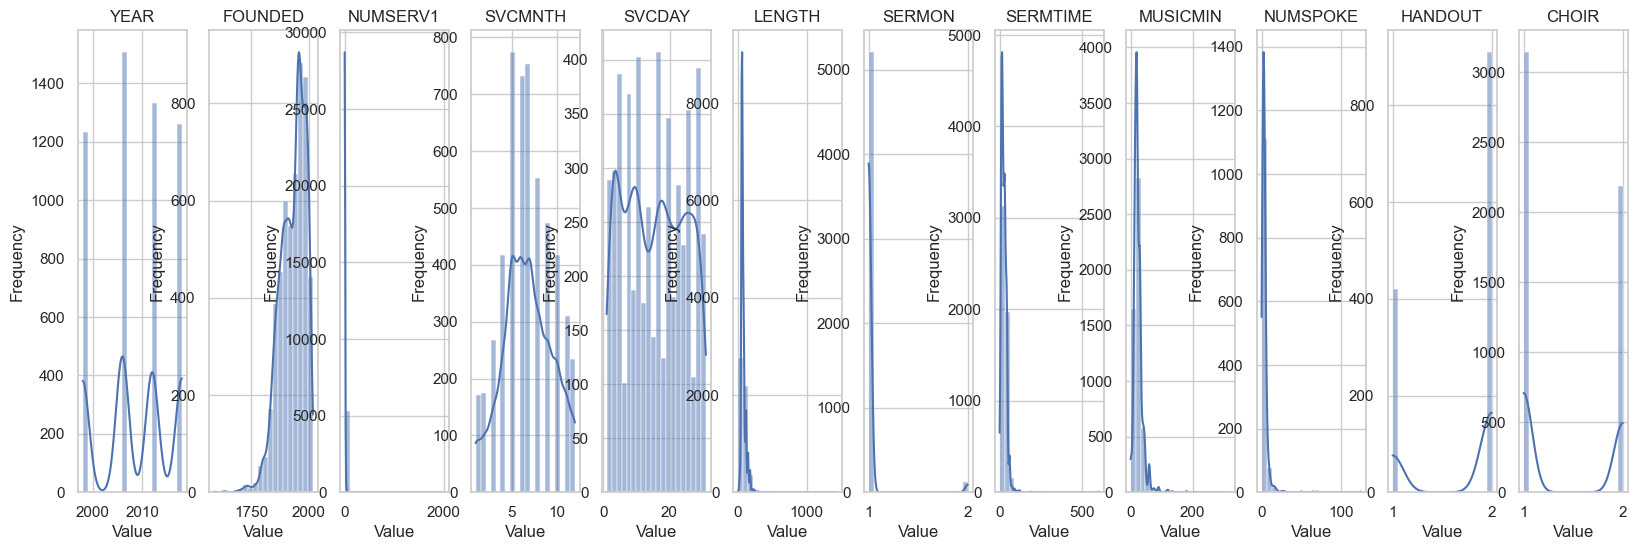

In [28]:
# Data Visualization
# Histogram of numerical features from select columns
columns_of_interest = ['YEAR', 'FOUNDED', 'NUMSERV1', 'SVCMNTH', 'SVCDAY', 'LENGTH', 'SERMON', 'SERMTIME', 'MUSICMIN', 'NUMSPOKE', 'HANDOUT', 'CHOIR']

sns.set(style="whitegrid")
plt.figure(figsize=(20, 6))

for i, column in enumerate(columns_of_interest, 1):
    plt.subplot(1, len(columns_of_interest), i)
    sns.histplot(data[column], bins=20, kde=True)
    plt.title(column)
    plt.xlabel("Value")
    plt.ylabel("Frequency")

## Seaborn Graph/Chart Theme

In [29]:
def set_seaborn_style(font_family, background_color, grid_color, text_color):
    sns.set_style({
        "axes.facecolor": background_color,
        "figure.facecolor": background_color,

        "grid.color": grid_color,
        "axes.edgecolor": grid_color,
        "axes.grid": True,
        "axes.axisbelow": True,
        
        "axes.labelcolor": text_color,
        "text.color": text_color,
        "font.family": font_family,
        "xtick.color": text_color,
        "ytick.color": text_color,

        "xtick.bottom": False,
        "xtick.top": False,
        "ytick.left": False,
        "ytick.right": False,

        "axes.spines.left": False,
        "axes.spines.bottom": True,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

background_color = "#006064"
grid_color = "#cccccc"
bar_color = "#009688"
text_color = "#ffffff"
font_family = "Arial"

set_seaborn_style(font_family, background_color, grid_color, text_color)

## About Denominations

C:\Users\natha\AppData\Local\Temp\ipykernel_6316\1675570573.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=denom_counts.index, y=denom_counts.values, palette=custom_palette, edgecolor=background_color)


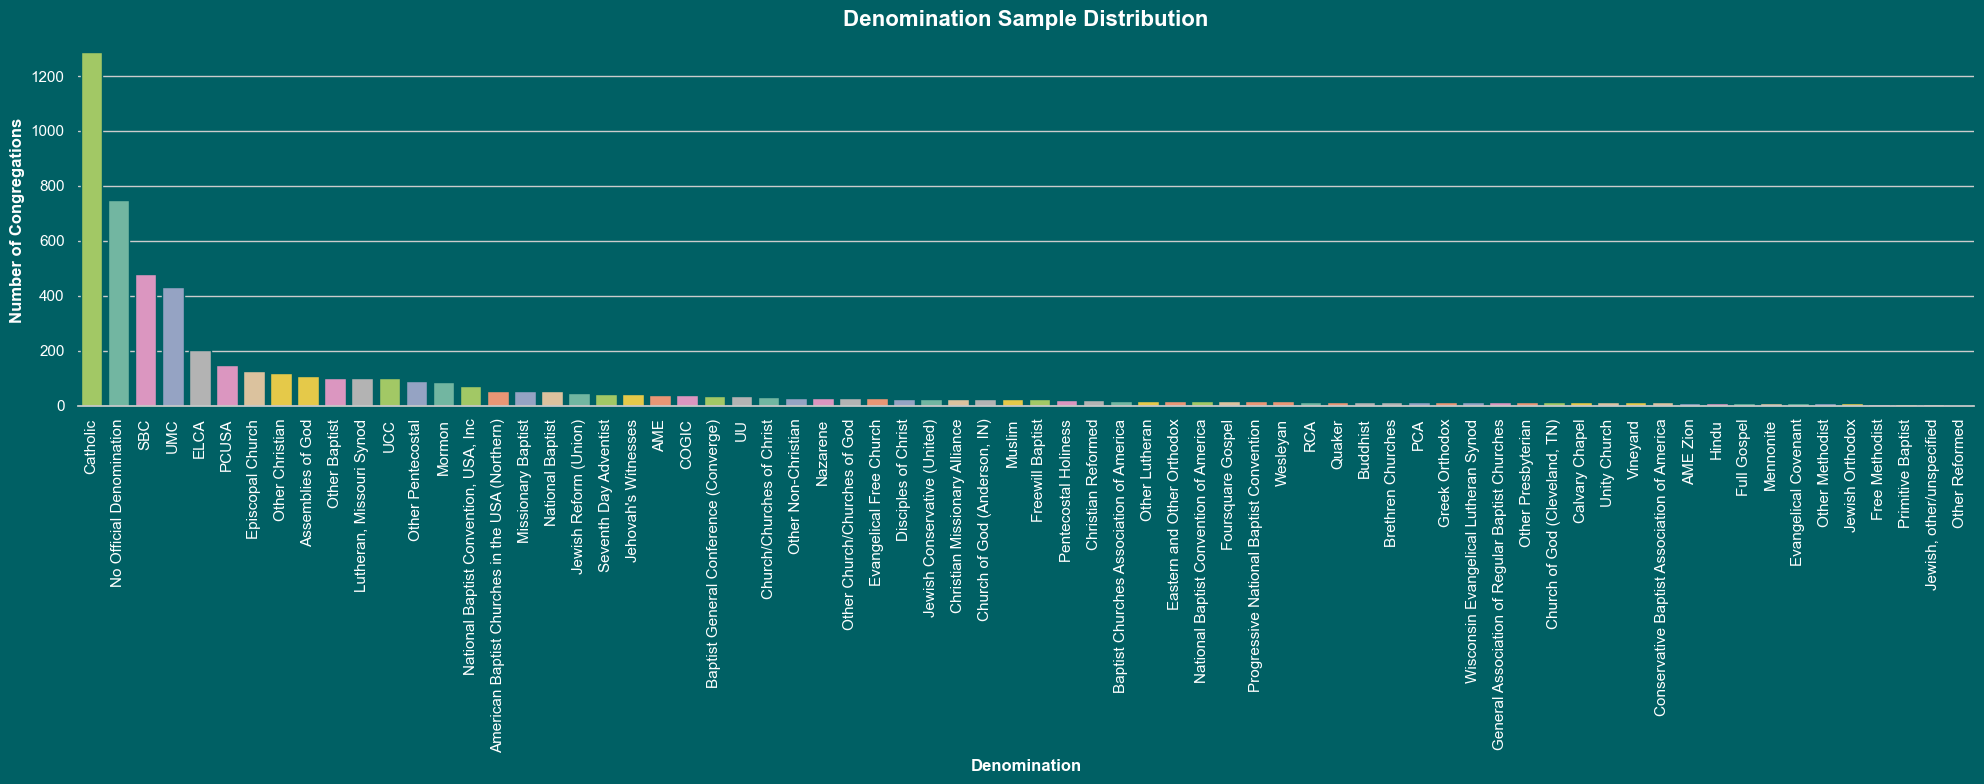

In [30]:
# Count the occurrences of each unique value in 'DENOM' column
denom_counts = data['DENOM'].value_counts()

# Create a bar chart
plt.figure(figsize=(20, 8))
sns.barplot(x=denom_counts.index, y=denom_counts.values, palette=custom_palette, edgecolor=background_color)

# Customize the plot
plt.title('Denomination Sample Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Denomination', fontsize=12, fontweight='bold')
plt.ylabel('Number of Congregations', fontweight='bold')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

## Basic Church/Facility Features Analysis

In [31]:
# List of features to include
bc_columns = ['DENOM','REGION','BLDGTYPE','VIEWBLDG','REMODEL','CHANGE']
bc_df = data[bc_columns].copy()

# drop all empty rows under CHANGE feature
bc_df.dropna(subset=['CHANGE'], inplace=True)

print(bc_df.head())
print()
print('Shape: ', bc_df.shape)
print()
print(bc_df.describe)

                         DENOM  REGION  BLDGTYPE  VIEWBLDG  REMODEL  \
2075  Lutheran, Missouri Synod       2      20.0       NaN      2.0   
2089                     PCUSA       2      20.0       NaN      2.0   
2099                  Catholic       2      20.0       NaN      2.0   
2102                       SBC       2      20.0       NaN      2.0   
2108  Lutheran, Missouri Synod       2      20.0       NaN      2.0   

                       CHANGE  
2075  Remained about the same  
2089                Decreased  
2099  Remained about the same  
2102  Remained about the same  
2108  Remained about the same  

Shape:  (1492, 6)

<bound method NDFrame.describe of                          DENOM  REGION  BLDGTYPE  VIEWBLDG  REMODEL  \
2075  Lutheran, Missouri Synod       2      20.0       NaN      2.0   
2089                     PCUSA       2      20.0       NaN      2.0   
2099                  Catholic       2      20.0       NaN      2.0   
2102                       SBC       2     

In [32]:
print(bc_df['CHANGE'].unique)

<bound method Series.unique of 2075    Remained about the same
2089                  Decreased
2099    Remained about the same
2102    Remained about the same
2108    Remained about the same
                 ...           
5328                  Decreased
5329                  Increased
5330                  Decreased
5331    Remained about the same
5332                  Decreased
Name: CHANGE, Length: 1492, dtype: object>


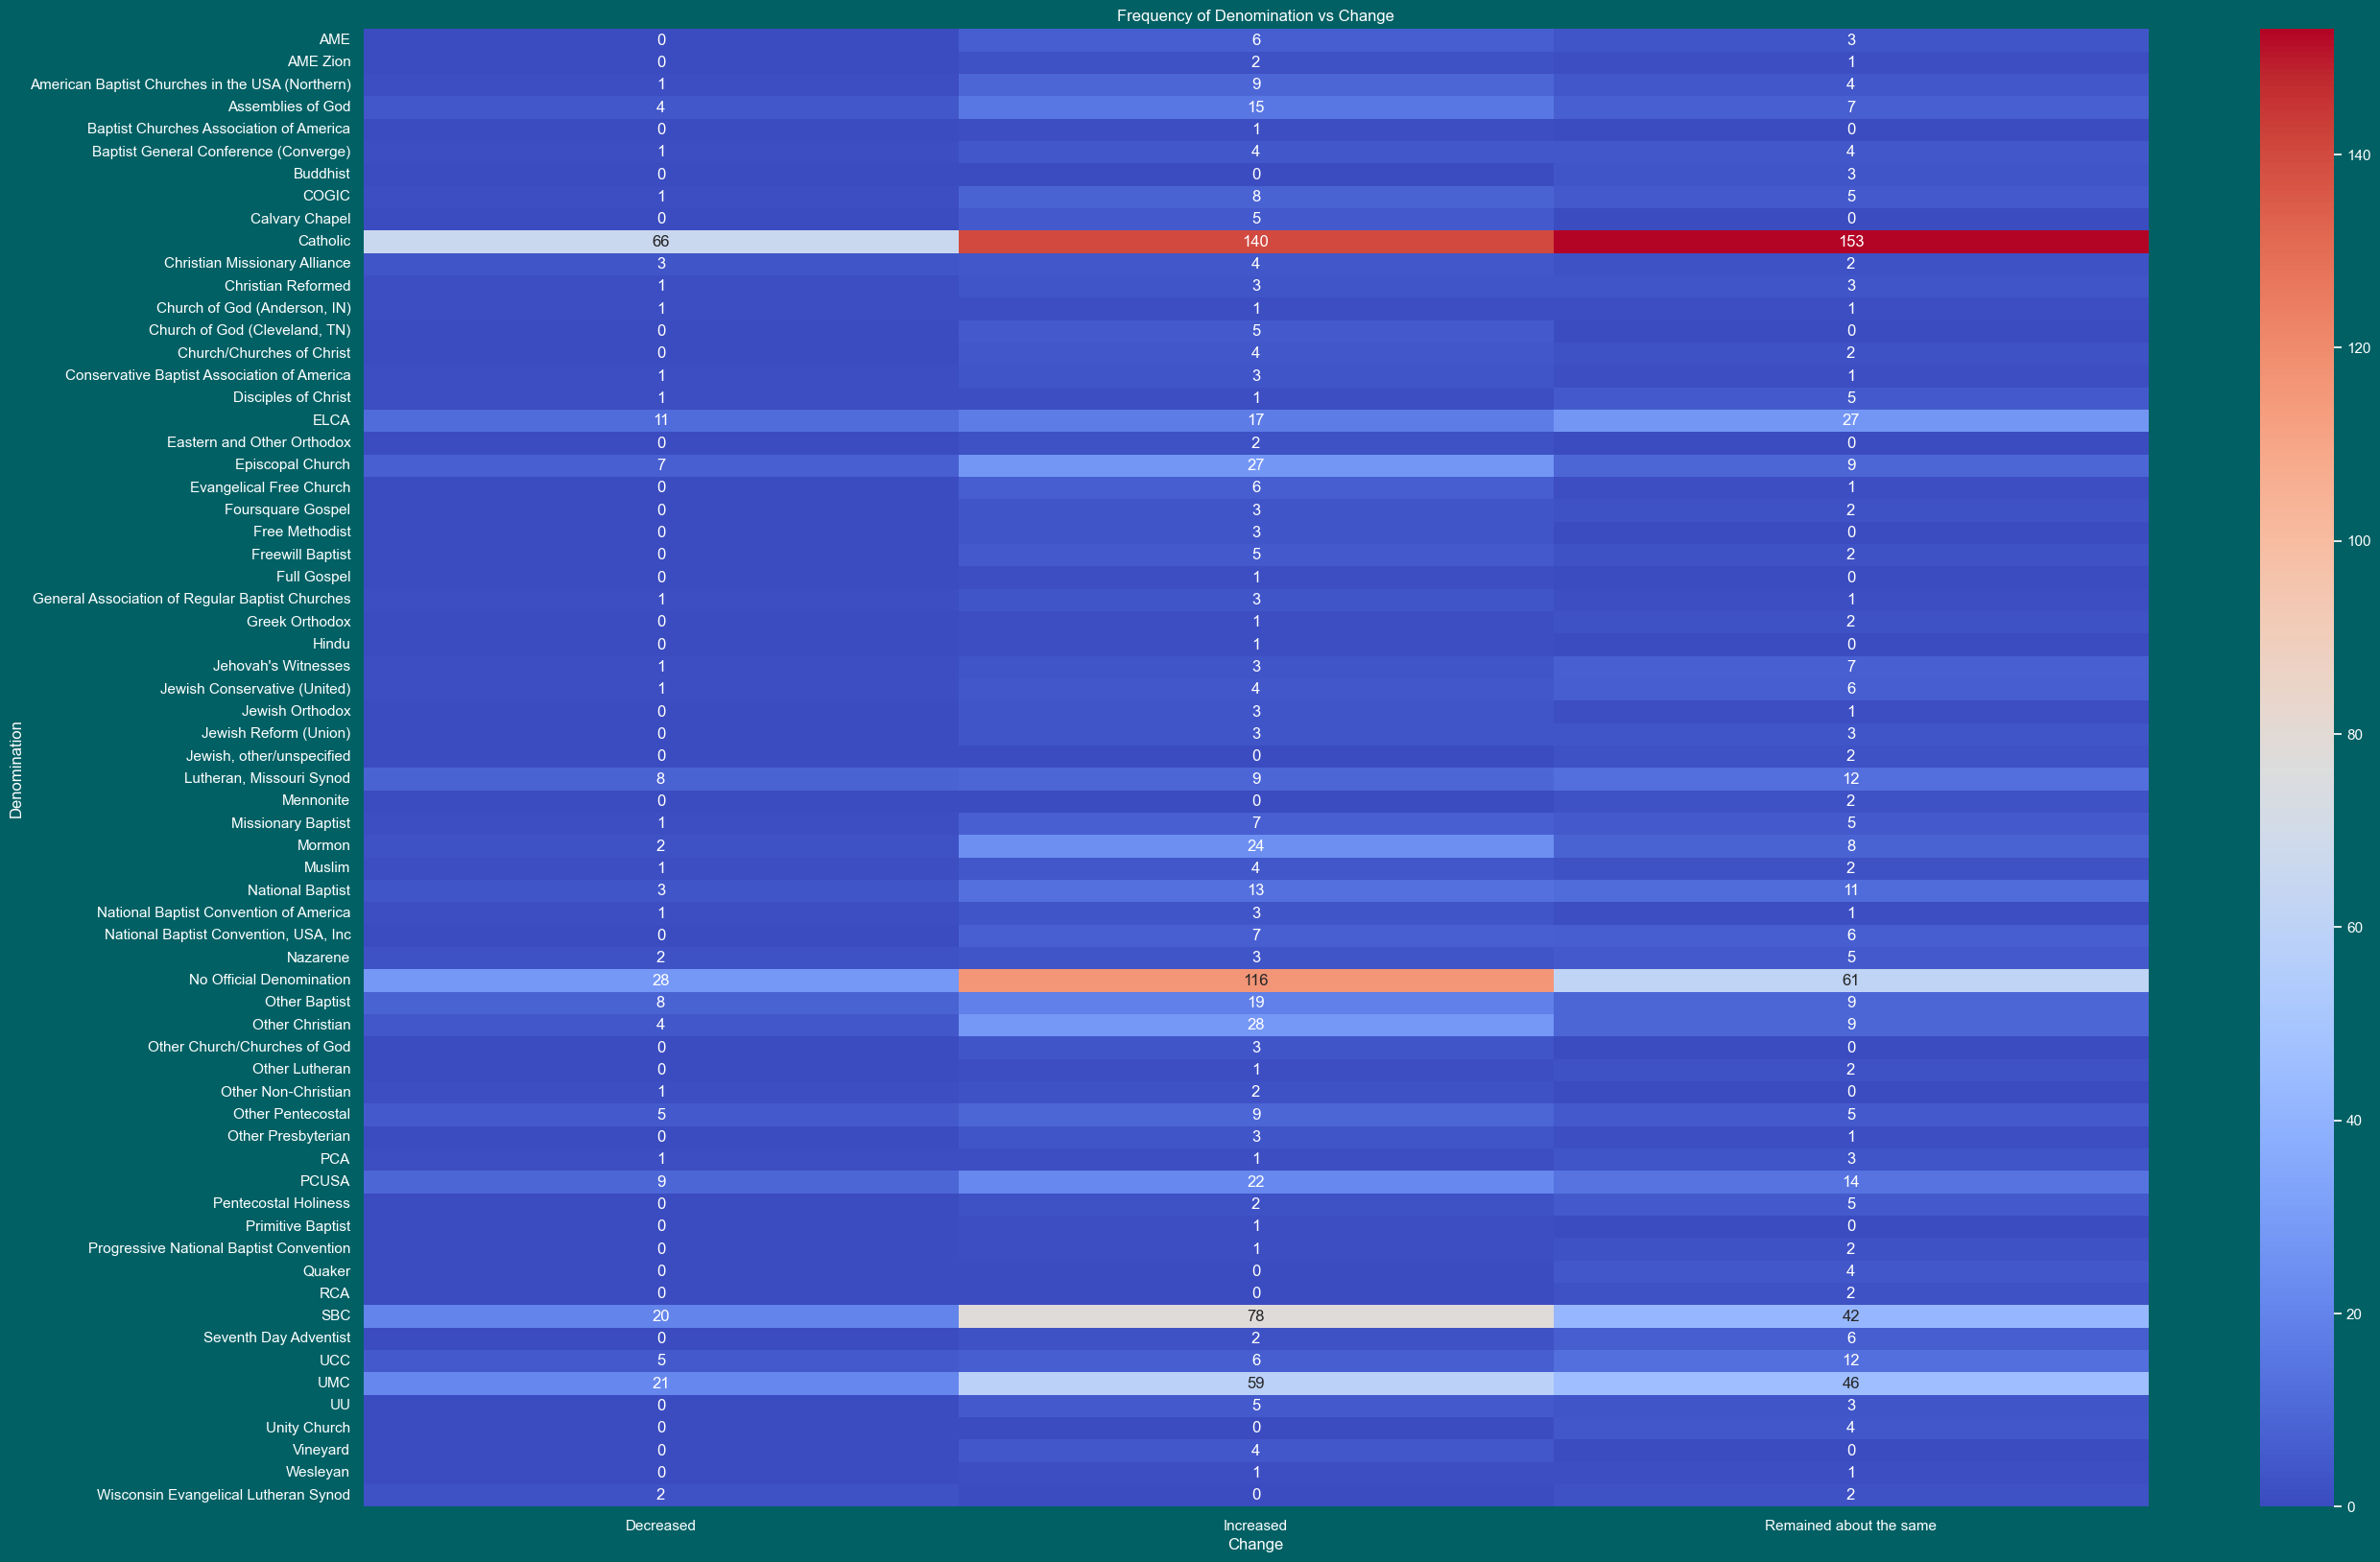

In [33]:
# Create a cross-tabulation (contingency table) of DENOM vs CHANGE
cross_table = pd.crosstab(data['DENOM'], data['CHANGE'])

# Plot heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(cross_table, cmap='coolwarm', annot=True, fmt='d')
plt.title('Frequency of Denomination vs Change')
plt.xlabel('Change')
plt.ylabel('Denomination')
plt.show()

C:\Users\natha\AppData\Local\Temp\ipykernel_6316\2367327347.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=change_counts_prop, x='DENOM', y='Increase vs Decrease + Same', palette=custom_palette, label='Increase vs Decrease + Same')
C:\Users\natha\AppData\Local\Temp\ipykernel_6316\2367327347.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=change_counts_prop, x='DENOM', y='Decrease vs Increase + Same', palette=custom_palette, label='Decrease vs Increase + Same')


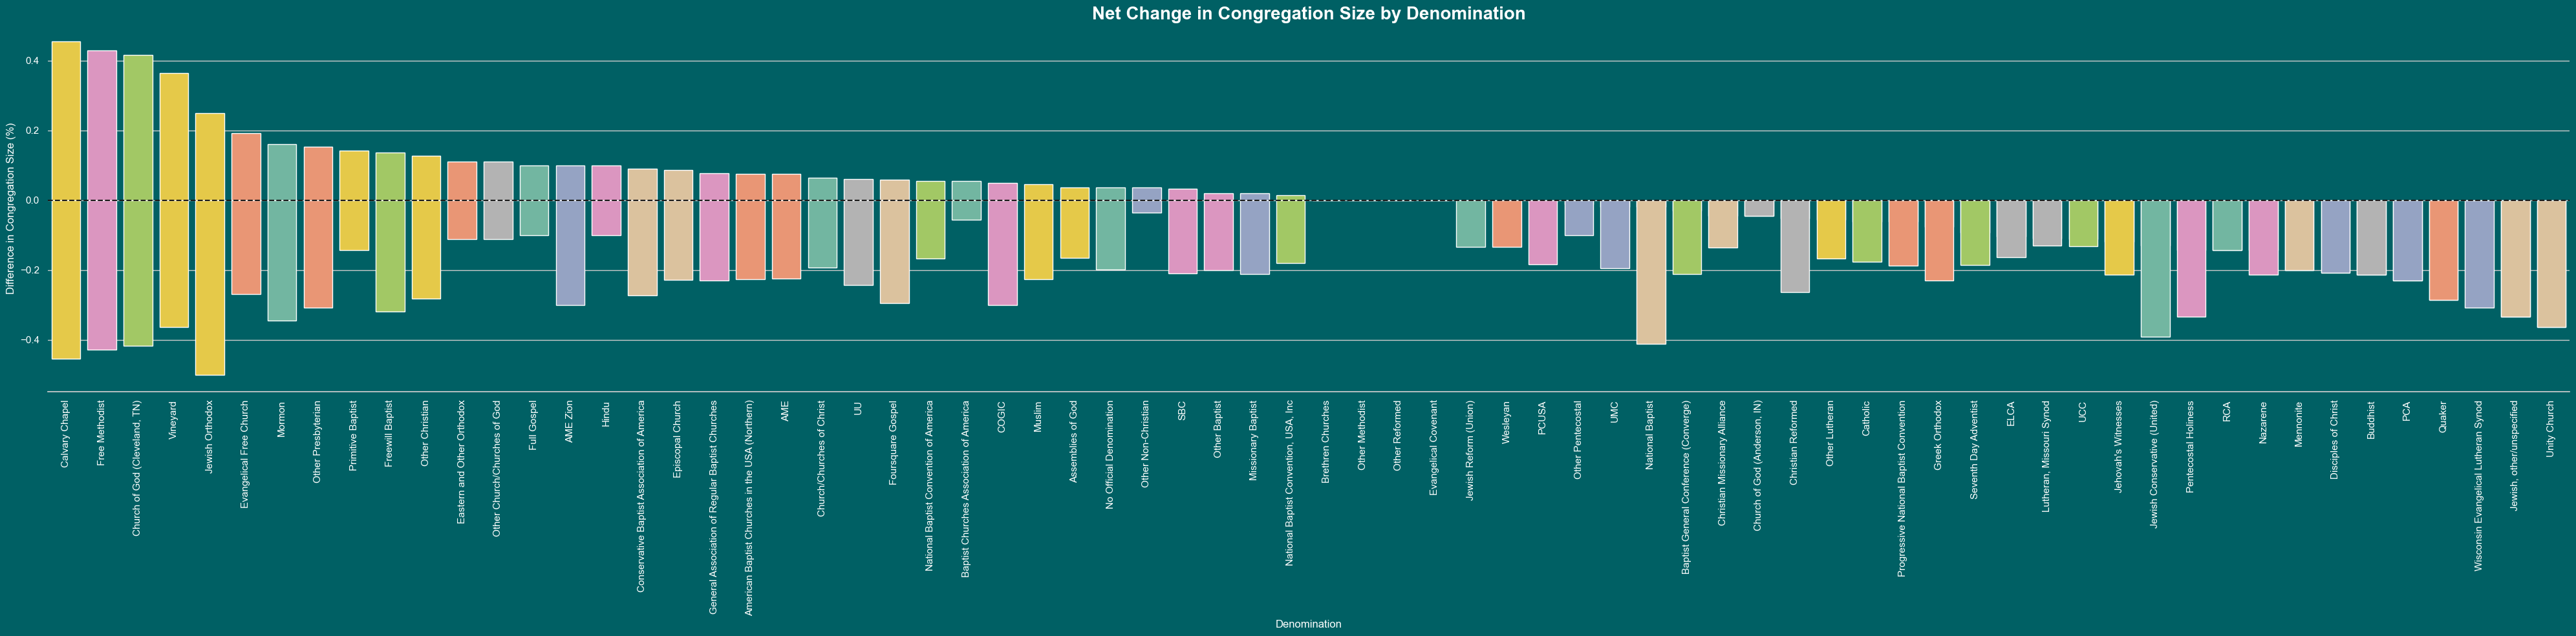

In [34]:
# Differences in the CHANGE column

# Calculate counts of each category by DENOM
change_counts = pd.crosstab(data['DENOM'], data['CHANGE'], dropna=False)

# Calculate proportions
change_counts['Total'] = change_counts.sum(axis=1)
change_counts_prop = change_counts.div(change_counts['Total'], axis=0)

# Calculate differences
change_counts_prop['Increase vs Decrease + Same'] = (
    change_counts_prop['Increased'] - 
    (change_counts_prop['Decreased'] + change_counts_prop['Remained about the same'])
)
change_counts_prop['Decrease vs Increase + Same'] = (
    change_counts_prop['Decreased'] - 
    (change_counts_prop['Increased'] + change_counts_prop['Remained about the same'])
)

# Sort by 'Increase vs Decrease + Same' difference in descending order
change_counts_prop = change_counts_prop.sort_values(by='Increase vs Decrease + Same', ascending=False)

# Reset index for plotting
change_counts_prop = change_counts_prop.reset_index()

# Plotting
plt.figure(figsize=(40, 10))
sns.barplot(data=change_counts_prop, x='DENOM', y='Increase vs Decrease + Same', palette=custom_palette, label='Increase vs Decrease + Same')
sns.barplot(data=change_counts_prop, x='DENOM', y='Decrease vs Increase + Same', palette=custom_palette, label='Decrease vs Increase + Same')
plt.axhline(0, color='k', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Denomination')
plt.ylabel('Difference in Congregation Size (%)')
plt.title('Net Change in Congregation Size by Denomination', fontsize=20, fontweight='bold')  # Adjust title font size and weight)
#plt.legend()
plt.xticks(rotation=90) # Rotate x-axis labels vertically
plt.tight_layout()
plt.show()
plt.show()

C:\Users\natha\AppData\Local\Temp\ipykernel_6316\2924234167.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_15_denoms, x='DENOM', y='Increase vs Decrease + Same', palette=custom_palette)


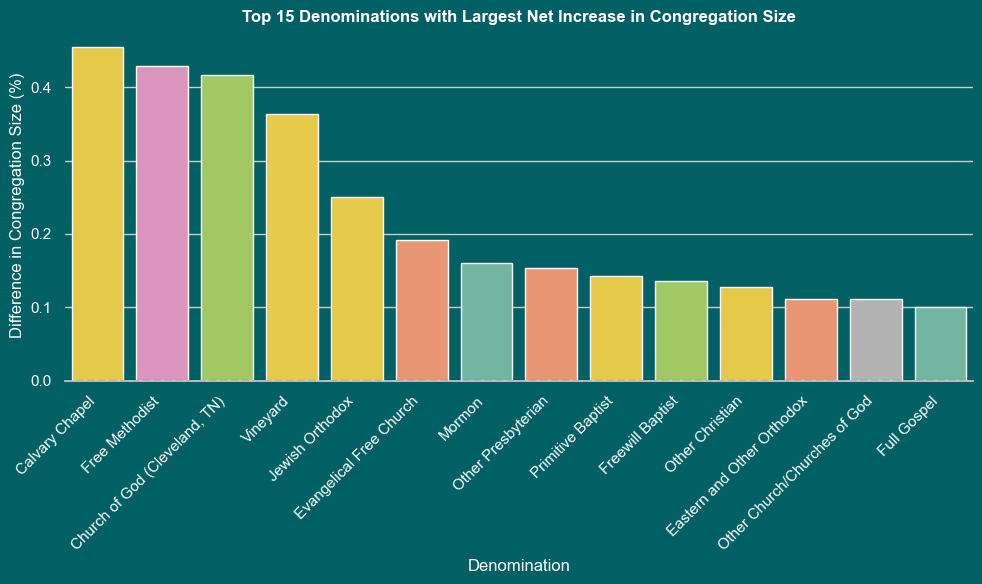

In [35]:
# Select top 15 denominations with the largest positive change
top_15_denoms = change_counts_prop.head(15)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=top_15_denoms, x='DENOM', y='Increase vs Decrease + Same', palette=custom_palette)
plt.axhline(0, color='k', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Denomination')
plt.ylabel('Difference in Congregation Size (%)')
plt.title('Top 15 Denominations with Largest Net Increase in Congregation Size', fontweight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

C:\Users\natha\AppData\Local\Temp\ipykernel_6316\1744189218.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_15_denoms.index, y=top_15_denoms.values, palette=custom_palette)


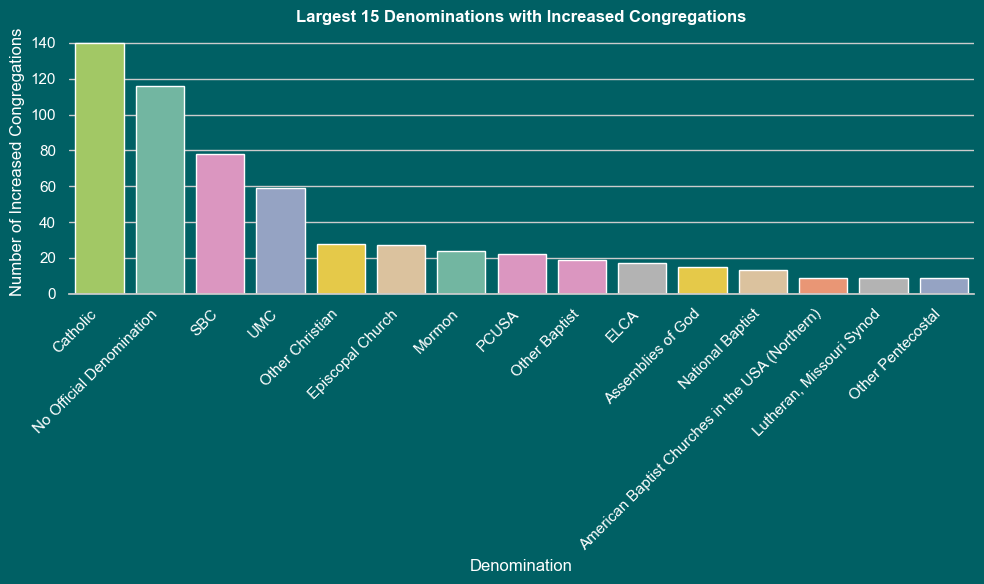

In [36]:
# Filter the DataFrame for rows where 'CHANGE' is "Increased"
increased_data = data[data['CHANGE'] == 'Increased']

# Count occurrences of each denomination
denom_counts = increased_data['DENOM'].value_counts()

# Select the top 15 denominations
top_15_denoms = denom_counts.head(15)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=top_15_denoms.index, y=top_15_denoms.values, palette=custom_palette)
plt.xlabel('Denomination')
plt.ylabel('Number of Increased Congregations')
plt.title('Largest 15 Denominations with Increased Congregations', fontweight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [37]:
# Apply One Hot Encoding to 'CHANGE' feature
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Drop first category and get a dense array
encoded_change = encoder.fit_transform(bc_df[['CHANGE']])

# Get feature names for encoded columns
encoded_columns = encoder.get_feature_names_out(['CHANGE'])

# Create DataFrame from encoded columns
encoded_change_df = pd.DataFrame(encoded_change, columns=encoded_columns)

# Reset index of bc_df and encoded_change_df for proper concatenation
bc_df.reset_index(drop=True, inplace=True)
encoded_change_df.reset_index(drop=True, inplace=True)

# Concatenate encoded columns to original DataFrame and drop the original 'CHANGE' column
bc_df_encoded = pd.concat([bc_df, encoded_change_df], axis=1).drop(['CHANGE'], axis=1)

# Print the shape and statistics of the DataFrame
print('Shape: ', bc_df_encoded.shape)
print()
print(bc_df_encoded.describe())

Shape:  (1492, 7)

            REGION     BLDGTYPE  VIEWBLDG      REMODEL  CHANGE_Increased  \
count  1492.000000  1490.000000       0.0  1408.000000       1492.000000   
mean      2.634718    19.820134       NaN     1.673295          0.487265   
std       0.957137     1.821408       NaN     0.469175          0.500005   
min       1.000000     1.000000       NaN     1.000000          0.000000   
25%       2.000000    20.000000       NaN     1.000000          0.000000   
50%       3.000000    20.000000       NaN     2.000000          0.000000   
75%       3.000000    20.000000       NaN     2.000000          1.000000   
max       4.000000    21.000000       NaN     2.000000          1.000000   

       CHANGE_Remained about the same  
count                     1492.000000  
mean                         0.363271  
std                          0.481103  
min                          0.000000  
25%                          0.000000  
50%                          0.000000  
75%             

In [38]:
# Perform One-Hot Encoding
denom_dummies = pd.get_dummies(bc_df_encoded['DENOM'], prefix='DENOM')

# Concatenate the encoded columns to the original DataFrame
bc_df_encoded = pd.concat([bc_df_encoded, denom_dummies], axis=1)

# Drop the original 'DENOM' column
bc_df_encoded.drop(['DENOM'], axis=1, inplace=True)

# Print the head of the DataFrame to verify
print(bc_df_encoded.head())
print()
print('Shape: ', bc_df_encoded.shape)


   REGION  BLDGTYPE  VIEWBLDG  REMODEL  CHANGE_Increased  \
0       2      20.0       NaN      2.0               0.0   
1       2      20.0       NaN      2.0               0.0   
2       2      20.0       NaN      2.0               0.0   
3       2      20.0       NaN      2.0               0.0   
4       2      20.0       NaN      2.0               0.0   

   CHANGE_Remained about the same  DENOM_AME  DENOM_AME Zion  \
0                             1.0      False           False   
1                             0.0      False           False   
2                             1.0      False           False   
3                             1.0      False           False   
4                             1.0      False           False   

   DENOM_American Baptist Churches in the USA (Northern)  \
0                                              False       
1                                              False       
2                                              False       
3             

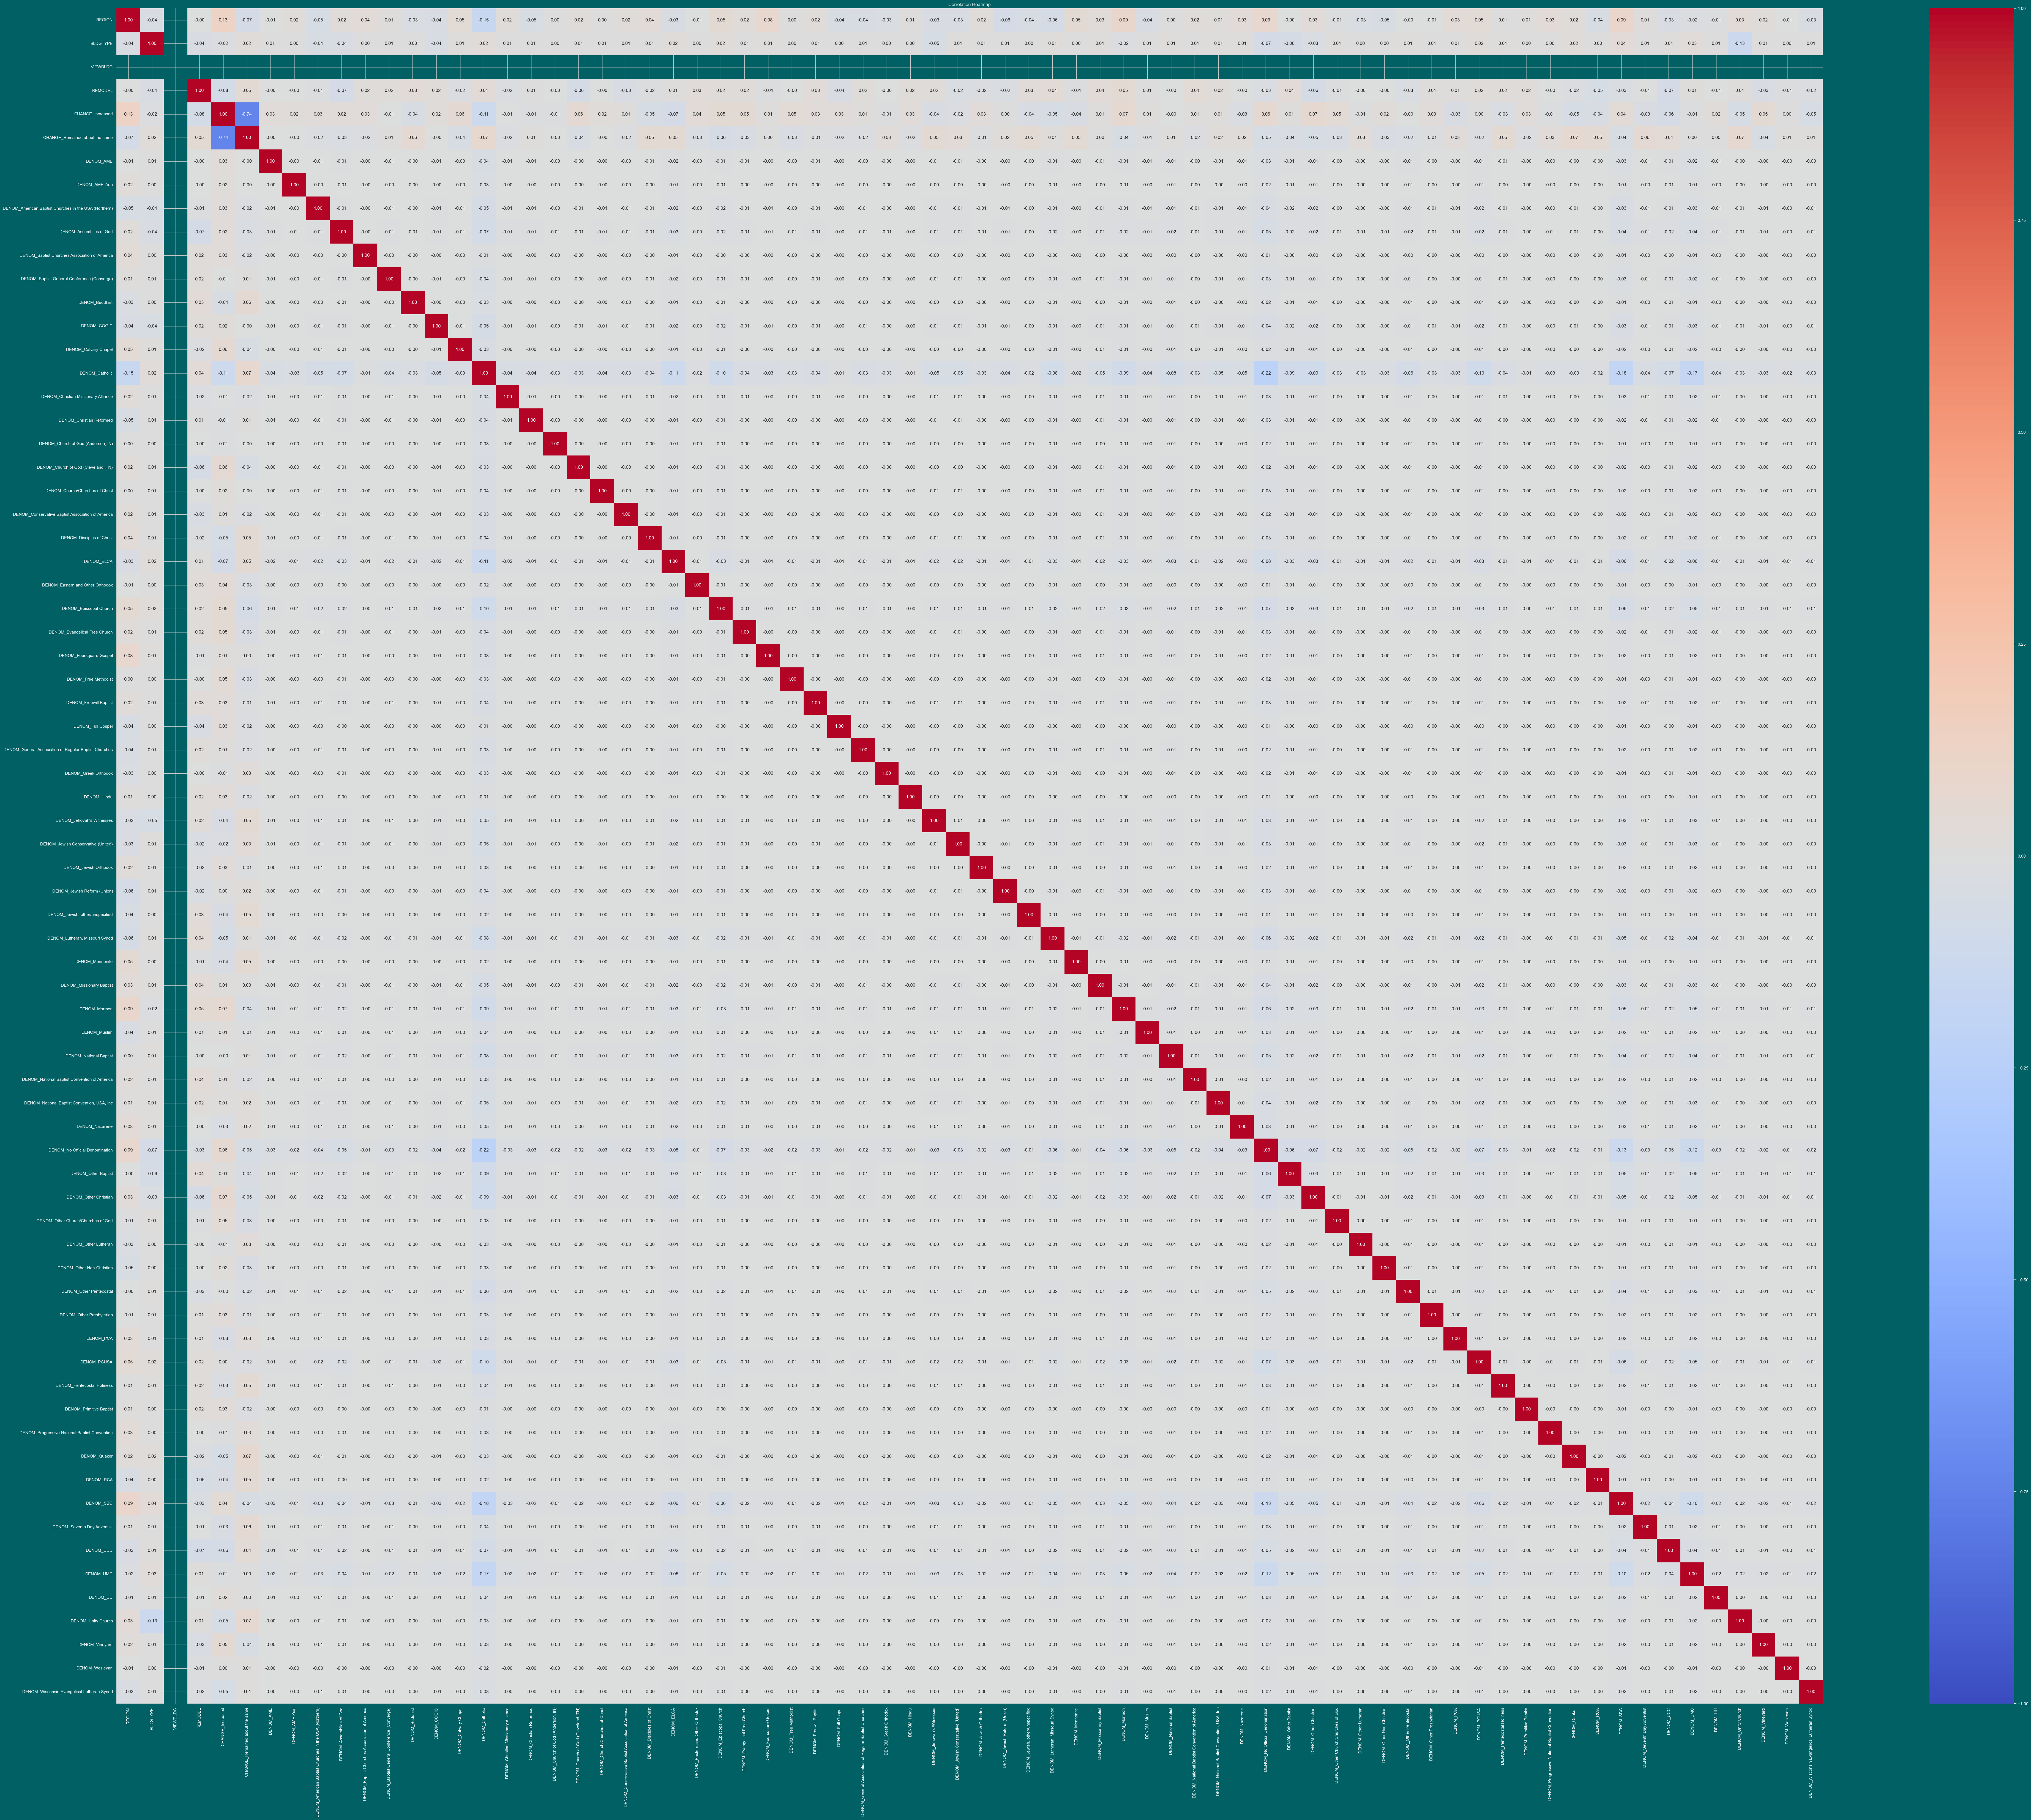

In [39]:
# Calculate correlation matrix
correlation_matrix = bc_df_encoded.corr()

# Create a heatmap
plt.figure(figsize=(100, 80))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

## Basic Worship Analysis

In [40]:
# List of features to include
bw_columns = ['NUMSERV1','LENGTH','SERMON','SERMTIME','SPKRDWN','MUSICMIN','GREET','ROBE','LAUGH','PROGRAM','CHANGE']
bW_df = data[bw_columns].copy()
print(bW_df.head())
print(bW_df.shape)

   NUMSERV1  LENGTH  SERMON  SERMTIME  SPKRDWN  MUSICMIN  GREET  ROBE  LAUGH  \
0      14.0    65.0     1.0      30.0      NaN      18.0    1.0   2.0    NaN   
1       8.0    85.0     1.0      25.0      NaN      30.0    2.0   2.0    NaN   
2      19.0    60.0     1.0      35.0      NaN      10.0    1.0   2.0    NaN   
3      14.0    60.0     1.0      20.0      NaN      20.0    1.0   1.0    NaN   
4       8.0    60.0     1.0      30.0      NaN      19.0    1.0   2.0    NaN   

   PROGRAM CHANGE  
0      2.0    NaN  
1      2.0    NaN  
2      2.0    NaN  
3      1.0    NaN  
4      1.0    NaN  
(5333, 11)


In [41]:
# Count the number of NaN values in each column
nan_counts = bW_df.isna().sum()
print("\nNumber of NaN values in each column:")
print(nan_counts)


Number of NaN values in each column:
NUMSERV1      11
LENGTH        12
SERMON         7
SERMTIME      44
SPKRDWN     2556
MUSICMIN      60
GREET          7
ROBE        1238
LAUGH       4105
PROGRAM        3
CHANGE      3841
dtype: int64


In [42]:
# Preprocessing
# Drop NaN values from 'CHANGE' columns
bw_df_clean = bW_df.dropna(subset=['CHANGE'])

# Replace NaN values in 'SPKRDWN' and 'ROBE' columns with 2
bw_df_clean.loc[:, ['SPKRDWN', 'ROBE', 'GREET', 'LAUGH']] = bw_df_clean.loc[:, ['SPKRDWN', 'ROBE', 'GREET', 'LAUGH']].fillna(2)

# Replace NaN values in 'NUMSERV1', 'LENGTH', 'SERMON', 'SERMTIME', 'MUSICMIN', 'GREET', 'PROGRAM' columns with the mean from each column
columns_to_replace_with_mean = ['NUMSERV1', 'LENGTH', 'SERMTIME', 'MUSICMIN']
mean_values = bw_df_clean[columns_to_replace_with_mean].mean()
bw_df_clean.loc[:, columns_to_replace_with_mean] = bw_df_clean.loc[:, columns_to_replace_with_mean].fillna(mean_values)

# List of columns where you want to replace the value 2 with 0
columns_to_replace = ['SERMON', 'SPKRDWN', 'GREET', 'ROBE', 'LAUGH', 'PROGRAM']
# Replace the value 2 with 0 in the specified columns
bw_df_clean.loc[:, columns_to_replace] = bw_df_clean.loc[:, columns_to_replace].replace(2, 0)

nan_counts = bw_df_clean.isna().sum()
print("\nNumber of NaN values in each column after preprocessing:")
print(nan_counts)
print(bw_df_clean.shape)


Number of NaN values in each column after preprocessing:
NUMSERV1    0
LENGTH      0
SERMON      0
SERMTIME    0
SPKRDWN     0
MUSICMIN    0
GREET       0
ROBE        0
LAUGH       0
PROGRAM     0
CHANGE      0
dtype: int64
(1492, 11)


In [43]:
# Standardize the data
scaler = StandardScaler()
bw_df_standardized = pd.DataFrame(scaler.fit_transform(bw_df_clean), columns=bw_df_clean.columns)
print(bw_df_standardized.head())

ValueError: could not convert string to float: 'Remained about the same'

In [ ]:
# Create a correlation matrix
correlation_matrix = bw_df_standardized.corr()
# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# List of columns to include in the scatter plot
columns_to_plot = ['NUMSERV1', 'LENGTH', 'SERMON']

# Scatter plot of specified columns vs 'CHANGE'
plt.figure(figsize=(10, 6))
for column in columns_to_plot:
    plt.scatter(bw_df_standardized[column], bw_df_standardized['CHANGE'], label=column, alpha=0.5)

plt.title('Scatter Plots of NUMSERV1, LENGTH, and SERMON vs CHANGE')
plt.xlabel('Value')
plt.ylabel('CHANGE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Function to remove outliers using IQR
def remove_outliers(bw_df_standardized, columns):
    for column in columns:
        Q1 = bw_df_standardized[column].quantile(0.25)
        Q3 = bw_df_standardized[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        bw_df_standardized = bw_df_standardized[(bw_df_standardized[column] >= lower_bound) & (bw_df_standardized[column] <= upper_bound)]
    return bw_df_standardized

# List of columns from which to remove outliers
columns_to_check = ['NUMSERV1', 'LENGTH', 'SERMON']

# Remove outliers from the specified columns
bw_df_standardized = remove_outliers(bw_df_standardized, columns_to_check)

# Verify the shape of the cleaned DataFrame
print(bw_df_standardized.shape)

# Scatter plot of cleaned specified columns vs 'CHANGE'
plt.figure(figsize=(10, 6))
for column in columns_to_check:
    plt.scatter(bw_df_standardized[column], bw_df_standardized['CHANGE'], label=column, alpha=0.5)

plt.title('Scatter Plots of NUMSERV1, LENGTH, and SERMON vs CHANGE (After Removing Outliers)')
plt.xlabel('Value')
plt.ylabel('CHANGE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# List of columns to plot
columns_to_plot = ['NUMSERV1', 'LENGTH', 'SERMON']

# Create boxplots for the specified columns
plt.figure(figsize=(15, 5))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=bw_df_standardized[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [ ]:
# Ensure the data is clean and ready for modeling
columns_to_use = ['NUMSERV1', 'LENGTH'] #, 'SERMON', 'SPKRDWN', 'ROBE', 'GREET', 'LAUGH'
X = bw_df_standardized[columns_to_use]

# Convert 'CHANGE' to categorical if it's not already
bw_df_standardized['CHANGE'] = bw_df_standardized['CHANGE'].astype('int').astype('category')
y = bw_df_standardized['CHANGE']

# Check class distribution
print("Class distribution in 'CHANGE':")
print(y.value_counts())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=1)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Initialize and train the logistic regression model with class weights
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=1)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Initialize and train the Random Forest model with class weights
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best estimator
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf, zero_division=1)

print(f'Best Random Forest Model: {best_rf_model}')
print(f'Accuracy: {accuracy_rf}')
print(f'Confusion Matrix:\n{conf_matrix_rf}')
print(f'Classification Report:\n{class_report_rf}')

# Plotting the confusion matrix for Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=best_rf_model.classes_, yticklabels=best_rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [ ]:
# Get feature importances from the trained Random Forest model
feature_importances = best_rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': columns_to_use, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

# Plotting feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [ ]:
# Calculate the average value of 'NUMSERV1', 'LENGTH'
average_numserv1 = bw_df_standardized['NUMSERV1'].mean()
average_length = bw_df_standardized['LENGTH'].mean()

# Define the three scenarios for 'NUMSERV1' and 'LENGTH'
scenarios = ['Average', 'Twice Average', 'Half Average']
numserv1_values = [average_numserv1, 2 * average_numserv1, 0.5 * average_numserv1]
length_values = [average_length, 2 * average_length, 0.5 * average_length]

# Predict 'CHANGE' values for each scenario using the trained Random Forest model
change_values = []
for numserv1, length in zip(numserv1_values, length_values):
    # Predict 'CHANGE' using the trained Random Forest model
    predicted_change = best_rf_model.predict([[numserv1, length]])
    change_values.append(predicted_change[0])  # Append the predicted 'CHANGE' value to the list

# Create a bar chart for 'NUMSERV1'
plt.figure(figsize=(10, 6))
plt.bar(scenarios, change_values, color='skyblue')

# Add labels and title
plt.xlabel('NUMSERV1 Scenarios')
plt.ylabel('Predicted CHANGE')
plt.title('Impact of NUMSERV1 on Predicted CHANGE (Random Forest Model)')

# Show plot
plt.grid(True)
plt.show()

# Repeat for 'LENGTH'
# Predict 'CHANGE' values for each scenario using the trained Random Forest model
change_values = []
for numserv1, length in zip(numserv1_values, length_values):
    # Predict 'CHANGE' using the trained Random Forest model
    predicted_change = best_rf_model.predict([[numserv1, length]])
    change_values.append(predicted_change[0])  # Append the predicted 'CHANGE' value to the list

# Create a bar chart for 'LENGTH'
plt.figure(figsize=(10, 6))
plt.bar(scenarios, change_values, color='salmon')

# Add labels and title
plt.xlabel('LENGTH Scenarios')
plt.ylabel('Predicted CHANGE')
plt.title('Impact of LENGTH on Predicted CHANGE (Random Forest Model)')

# Show plot
plt.grid(True)
plt.show()

In [ ]:
# Calculate the median 'LENGTH' and 'NUMSERV1'
median_length = data['LENGTH'].median()
median_numserv1 = data['NUMSERV1'].median()

print(f"Median LENGTH: {median_length}")
print(f"Median NUMSERV1: {median_numserv1}")

In [ ]:
# Define the increase scenarios for 'NUMSERV1' and 'LENGTH'
numserv1_increase = 2 * average_numserv1
length_increase = 2 * average_length

# Predict probabilities for 'CHANGE' > 0.25 and 'CHANGE' > 0.5 given the increase in 'NUMSERV1' and 'LENGTH'
probabilities_nums = best_rf_model.predict_proba([[numserv1_increase, average_length]])
prob_gt_025_nums = sum(prob for prob in probabilities_nums[0] if prob > 0.25)
prob_gt_05_nums = sum(prob for prob in probabilities_nums[0] if prob > 0.5)

probabilities_length = best_rf_model.predict_proba([[average_numserv1, length_increase]])
prob_gt_025_length = sum(prob for prob in probabilities_length[0] if prob > 0.25)
prob_gt_05_length = sum(prob for prob in probabilities_length[0] if prob > 0.5)

# Display the probabilities
print(f"Probability of 'CHANGE' > 0.25 with increased NUMSERV1: {prob_gt_025_nums}")
print(f"Probability of 'CHANGE' > 0.5 with increased NUMSERV1: {prob_gt_05_nums}")

print(f"Probability of 'CHANGE' > 0.25 with increased LENGTH: {prob_gt_025_length}")
print(f"Probability of 'CHANGE' > 0.5 with increased LENGTH: {prob_gt_05_length}")

In [ ]:
# Define the decrease scenarios for 'NUMSERV1' and 'LENGTH'
numserv1_decrease = 0.5 * average_numserv1
length_decrease = 0.5 * average_length

# Predict probabilities for 'CHANGE' > 0.25 and 'CHANGE' > 0.5 given the decrease in 'NUMSERV1' and 'LENGTH'
probabilities_nums_decrease = best_rf_model.predict_proba([[numserv1_decrease, average_length]])
prob_gt_025_nums_decrease = sum(prob for prob in probabilities_nums_decrease[0] if prob > 0.25)
prob_gt_05_nums_decrease = sum(prob for prob in probabilities_nums_decrease[0] if prob > 0.5)

probabilities_length_decrease = best_rf_model.predict_proba([[average_numserv1, length_decrease]])
prob_gt_025_length_decrease = sum(prob for prob in probabilities_length_decrease[0] if prob > 0.25)
prob_gt_05_length_decrease = sum(prob for prob in probabilities_length_decrease[0] if prob > 0.5)

# Display the probabilities
print(f"Probability of 'CHANGE' > 0.25 with decreased NUMSERV1: {prob_gt_025_nums_decrease}")
print(f"Probability of 'CHANGE' > 0.5 with decreased NUMSERV1: {prob_gt_05_nums_decrease}")

print(f"Probability of 'CHANGE' > 0.25 with decreased LENGTH: {prob_gt_025_length_decrease}")
print(f"Probability of 'CHANGE' > 0.5 with decreased LENGTH: {prob_gt_05_length_decrease}")

In [ ]:
# Define the increase scenarios for 'NUMSERV1' and 'LENGTH'
numserv1_increase = 2 * average_numserv1
length_increase = 2 * average_length

# Predict probabilities for 'CHANGE' > 0.25 and 'CHANGE' > 0.5 given the increase in 'NUMSERV1' and 'LENGTH'
probabilities_nums_increase = best_rf_model.predict_proba([[numserv1_increase, average_length]])
prob_gt_025_nums_increase = sum(prob for prob in probabilities_nums_increase[0] if prob > 0.25)
prob_gt_05_nums_increase = sum(prob for prob in probabilities_nums_increase[0] if prob > 0.5)

probabilities_length_increase = best_rf_model.predict_proba([[average_numserv1, length_increase]])
prob_gt_025_length_increase = sum(prob for prob in probabilities_length_increase[0] if prob > 0.25)
prob_gt_05_length_increase = sum(prob for prob in probabilities_length_increase[0] if prob > 0.5)

# Display the probabilities
print(f"Probability of 'CHANGE' > 0.25 with increased NUMSERV1: {prob_gt_025_nums_increase}")
print(f"Probability of 'CHANGE' > 0.5 with increased NUMSERV1: {prob_gt_05_nums_increase}")

print(f"Probability of 'CHANGE' > 0.25 with increased LENGTH: {prob_gt_025_length_increase}")
print(f"Probability of 'CHANGE' > 0.5 with increased LENGTH: {prob_gt_05_length_increase}")
# Define the decrease scenarios for 'NUMSERV1' and 'LENGTH'
numserv1_decrease = 0.5 * average_numserv1
length_decrease = 0.5 * average_length

# Predict probabilities for 'CHANGE' > 0.25 and 'CHANGE' > 0.5 given the decrease in 'NUMSERV1' and 'LENGTH'
probabilities_nums_decrease = best_rf_model.predict_proba([[numserv1_decrease, average_length]])
prob_gt_025_nums_decrease = sum(prob for prob in probabilities_nums_decrease[0] if prob > 0.25)
prob_gt_05_nums_decrease = sum(prob for prob in probabilities_nums_decrease[0] if prob > 0.5)

probabilities_length_decrease = best_rf_model.predict_proba([[average_numserv1, length_decrease]])
prob_gt_025_length_decrease = sum(prob for prob in probabilities_length_decrease[0] if prob > 0.25)
prob_gt_05_length_decrease = sum(prob for prob in probabilities_length_decrease[0] if prob > 0.5)

# Display the probabilities
print(f"Probability of 'CHANGE' > 0.25 with decreased NUMSERV1: {prob_gt_025_nums_decrease}")
print(f"Probability of 'CHANGE' > 0.5 with decreased NUMSERV1: {prob_gt_05_nums_decrease}")

print(f"Probability of 'CHANGE' > 0.25 with decreased LENGTH: {prob_gt_025_length_decrease}")
print(f"Probability of 'CHANGE' > 0.5 with decreased LENGTH: {prob_gt_05_length_decrease}")

# Define the scenarios
scenarios = ['Decrease', 'No Change', 'Increase']

# Define the probabilities for 'CHANGE' > 0.25 and 'CHANGE' > 0.5 for NUMSERV1
prob_gt_025_nums = [prob_gt_025_nums_decrease, prob_gt_025_nums, prob_gt_025_nums_increase]
prob_gt_05_nums = [prob_gt_05_nums_decrease, prob_gt_05_nums, prob_gt_05_nums_increase]

# Define the probabilities for 'CHANGE' > 0.25 and 'CHANGE' > 0.5 for LENGTH
prob_gt_025_length = [prob_gt_025_length_decrease, prob_gt_025_length, prob_gt_025_length_increase]
prob_gt_05_length = [prob_gt_05_length_decrease, prob_gt_05_length, prob_gt_05_length_increase]

# Create bar plots for NUMSERV1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(scenarios, prob_gt_025_nums, label='> 0.25', color='skyblue')
plt.bar(scenarios, prob_gt_05_nums, label='> 0.5', color='salmon', alpha=0.5)
plt.xlabel('NUMSERV1 Scenarios')
plt

In [ ]:
# Create bar plots for LENGTH
plt.subplot(1, 2, 2)
plt.bar(scenarios, prob_gt_025_length, label='> 0.25', color='skyblue')
plt.bar(scenarios, prob_gt_05_length, label='> 0.5', color='salmon', alpha=0.5)
plt.xlabel('LENGTH Scenarios')
plt.ylabel('Probability')
plt.title('Change in Probability with LENGTH')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Create bar plots for NUMSERV1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(scenarios, prob_gt_025_nums, label='> 0.25', color='skyblue')
plt.bar(scenarios, prob_gt_05_nums, label='> 0.5', color='salmon', alpha=0.5)
plt.xlabel('NUMSERV1 Scenarios')
plt.ylabel('Probability')
plt.title('Change in Probability with NUMSERV1')

# Create bar plots for LENGTH
plt.subplot(1, 2, 2)
plt.bar(scenarios, prob_gt_025_length, label='> 0.25', color='skyblue')
plt.bar(scenarios, prob_gt_05_length, label='> 0.5', color='salmon', alpha=0.5)
plt.xlabel('LENGTH Scenarios')
plt.ylabel('Probability')
plt.title('Change in Probability with LENGTH')

# Add a common legend
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Musical Analysis